# Lab 08: Spatial analysis

Author: **N.J. de Winter** (*n.j.de.winter@vu.nl*)<br>
Assitant Professor Vrije Universiteit Amsterdam<br>
Statistics and Data Analysis Course


## Learning goals:

* Apply and improve your knowledge of Python and Jupyter
* Learn to work with spatial datasets and analyze the characteristics of spatial data.
* Learn to apply spatial analysis to create maps of variables based on a limited number of measurements in the area.
* Obtain a feeling for the reliability of spatial analysis and the trustworthyness of the resulting maps.
* Develop a feeling for how statistical tools can help you, but you still require *your interpretation* to draw conclusions.

## Introduction
In this lab, you will get to experiment for the first time with **spatial analysis**. Spatial analysis is a big and important field in data science, and you see the outcome of its application on a daily basis all around you: Think about temperature maps on the weather forecast, elevation maps you use in the field and maps used to plot and assess risk of hazards such as forest fires. Everything that is plotted on a map based on a limited number of datapoints is subject to some kind of spatial interpolation!

Needless to say, spatial analysis requires you to **think in multiple dimensions** (at least two), making statistical operations much more complex. Although this lab is just an introduction to make you familiar with spatial analysis techniques, it will relfect some of that complexity. Therefore, expect to be spending more time on this one than you are used to. Don't worry, we will take this step by step and as a result you will learn to produce some nice maps. (It will be worth it!)

**Exercise 1:** The data we need today (`geost_dat.mat`) is again in the `.mat` format. Remember from `Lab05` and `Lab07` how to load a file like this. Load the data and also import the packages `numpy`, `matplotlib.pyplot` and `loadmat` from `scipy.io` (you need the latter for loading the data).

In [4]:
# Make sure our figures show up in Jupyter
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
data = loadmat('geost_dat.mat')

## Inspecting the data

The data file contains `x` and `y` coordinates, and `z` values in a dictionary. We first have to read the `x`, `y` and `z`-variables from the dictionary. You have seen how to do this in `Lab07`.

**Exercise 2:** Extract the variables `x`, `y` and `z` from the data.

In [5]:
x = data['x'] # Extract x
y = data['y'] # Extract y
z = data['z'] # Extract z

Now, let’s plot all the locations for which we have data in a grid:

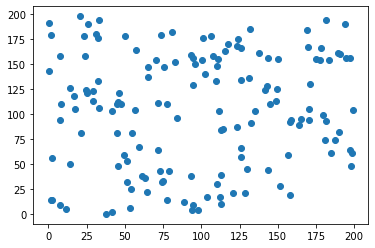

In [6]:
plt.figure()
plt.scatter(x, y)

## Creating a variogram

To analyze our spatial dataset, we want to calculate *distances* and *variances* between different pairs of observations. We will use the function `meshgrid` (`numpy` package) to facilitate this. First, let’s study the `help` of the function `meshgrid`, and then execute the function on the x and y coordinates, and z values:

In [7]:
help(np.meshgrid) # Call help for the meshgrid function

Help on function meshgrid in module numpy:

meshgrid(*xi, copy=True, sparse=False, indexing='xy')
    Return coordinate matrices from coordinate vectors.
    
    Make N-D coordinate arrays for vectorized evaluations of
    N-D scalar/vector fields over N-D grids, given
    one-dimensional coordinate arrays x1, x2,..., xn.
    
    .. versionchanged:: 1.9
       1-D and 0-D cases are allowed.
    
    Parameters
    ----------
    x1, x2,..., xn : array_like
        1-D arrays representing the coordinates of a grid.
    indexing : {'xy', 'ij'}, optional
        Cartesian ('xy', default) or matrix ('ij') indexing of output.
        See Notes for more details.
    
        .. versionadded:: 1.7.0
    sparse : bool, optional
        If True a sparse grid is returned in order to conserve memory.
        Default is False.
    
        .. versionadded:: 1.7.0
    copy : bool, optional
        If False, a view into the original arrays are returned in order to
        conserve memory.  Default

In [8]:
# Now apply the meshgrid function, we will create some new variables this way
X1, X2 = np.meshgrid(x, x)
Y1, Y2 = np.meshgrid(y, y)
Z1, Z2 = np.meshgrid(z, z)

**Question 1:** Study the output of the meshgrid function you just applied. Explain in your own words what the meshgrid function did.

**Answer 1:** The `np.meshgrid` function creates two square grids in which the number of rows and columns equals the number of observations. In the first grid, all values in the n-th column equal the n-th value of the input vector. In the second grid, all values in the n-th row equal the n-th value of the input vector.

The distance between all pairs of observations can now be calculated as:

In [13]:
D = np.sqrt(np.square((X1 - X2)) + np.square(Y1 - Y2)) # Calculate distance between all pairs of observations

The semivariance between all pairs of observations is:

In [12]:
G = 0.5 * (np.square(Z1 - Z2)) # Calculate semivariance between all pairs of observations

**Question 2:** Inspect the newly created matrices `D` and `G` and make sure you understand what information they contain. What is striking about the symmetry of these matrices?

**Answer 2:** Both matrices are symmetrical through their diagnoal (upper left - lower right) The upper right and lower left triangles in the D and G matrices are identical.

In [14]:
print(D)

[[  0.         188.96182286 183.6118256  ... 165.47660197 183.96835733
  166.81259815]
 [188.96182286   0.           5.44720112 ...  96.56439147  19.63784611
  107.05896039]
 [183.6118256    5.44720112   0.         ...  93.18639439  19.73425955
  105.51452317]
 ...
 [165.47660197  96.56439147  93.18639439 ...   0.         110.98877286
  178.61123957]
 [183.96835733  19.63784611  19.73425955 ... 110.98877286   0.
   87.8560641 ]
 [166.81259815 107.05896039 105.51452317 ... 178.61123957  87.8560641
    0.        ]]


We will create a matrix `I` that has ones for the lower triangle (and zeros for the upper right). We can then use this matrix `I` to select only one set (of the 2) of paired observations. To do this, first we create an index matrix (`indx`), which counts from 1 to the total number of observations (`z`):

In [15]:
indx = range(z.shape[0])

We then use this indx with meshgrid function to create matrices that duplicate the index vector in the column (`C`) and row (`R`) directions:

In [16]:
C, R = np.meshgrid(indx, indx)

Finally, we assign 1 to cells in a new matrix `I` when `R` > `C`, and otherwise the cells get assigned a 0:

In [17]:
I = R > C

Now we can make a scatter plot of semivariance versus distance for the cells where `I` is 1:

Text(0, 0.5, 'Semivariance')

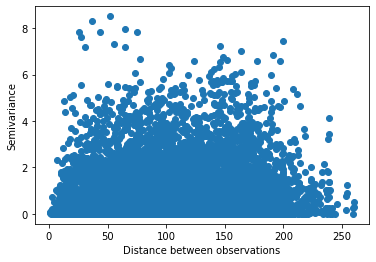

In [18]:
plt.scatter(D[I], G[I])
plt.xlabel('Distance between observations')
plt.ylabel('Semivariance')

This *variogram cloud* is somewhat useful for exploration, however, we need to calculate **mean semivariance** for binned distances if we really want to quantify spatial dependencies. We need to have a suitable **lag** interval to define classes over which we can average semivariances. The *mean minimum distance* between pairs is a good estimate for a lag interval. This *mean minimum distance* is the average of the minimum distance of each observation to its nearest neighbour observation. To calculate this, we need to get rid of the zero diagonal of the distance matrix `D`. We create a copy of our distance matrix, and set the diagonal to `nan` (meaning "not a number"):

In [19]:
D2 = np.copy(D) # Make a copy of the matrix D
i, j = np.indices(D2.shape) # here we get the x and y indices of the matrix
D2[i == j] = np.nan # the diagonal is where both indices are identical. We set those values to nan

After this, we can easily calculate the minimum distance for each observation, and the mean minimum distance of all observations:

In [21]:
lag = np.nanmean(np.nanmin(D2, axis = 0)) # Take the mean of all minimum differences

**Question 3:** What is the lag value of this dataset?

**Answer 3:** The lag value is approximately 8.01

In [22]:
print(lag)

8.010698943460342


Estimated variogram values tend to become more erratic with increasing distances between observations. As a rule of thumb, the *half maximum distance* is a suitable range (maximum value) for variogram analysis. The half maximum distance is:

In [23]:
hmd = np.max(D) / 2

**Question 4:** What is the value of the half maximum distance?

**Answer 4:** The hmd value is approximately 130.19

In [24]:
print(hmd)

130.19008189950569


Since the smallest bin is equal to the lag and the maximum is equal to the half maximum distance, the number of bins can be calculated as:

In [27]:
max_lags = np.floor(hmd / lag)
print(max_lags)

16.0


**Exercise 3:** The `max_lags` value is 16. Have a look at what the `floor` function (numpy) does. We used it here because we don't want a decimal number for the number of classes, but a whole integer.

In [29]:
help(np.floor)

Help on ufunc:

floor = <ufunc 'floor'>
    floor(x, /, out=None, *, where=True, casting='same_kind', order='K', dtype=None, subok=True[, signature, extobj])
    
    Return the floor of the input, element-wise.
    
    The floor of the scalar `x` is the largest integer `i`, such that
    `i <= x`.  It is often denoted as :math:`\lfloor x \rfloor`.
    
    Parameters
    ----------
    x : array_like
        Input data.
    out : ndarray, None, or tuple of ndarray and None, optional
        A location into which the result is stored. If provided, it must have
        a shape that the inputs broadcast to. If not provided or None,
        a freshly-allocated array is returned. A tuple (possible only as a
        keyword argument) must have length equal to the number of outputs.
    where : array_like, optional
        This condition is broadcast over the input. At locations where the
        condition is True, the `out` array will be set to the ufunc result.
        Elsewhere, the `out

Now, we will calculate in which distance bin each pair of observations belongs. Have a look at what the `ceil` function (numpy) does. Again, we want whole integers here because they represent distance class numbers.

In [30]:
help(np.ceil)
LAGS = np.ceil(D / lag)

Help on ufunc:

ceil = <ufunc 'ceil'>
    ceil(x, /, out=None, *, where=True, casting='same_kind', order='K', dtype=None, subok=True[, signature, extobj])
    
    Return the ceiling of the input, element-wise.
    
    The ceil of the scalar `x` is the smallest integer `i`, such that
    ``i >= x``.  It is often denoted as :math:`\lceil x \rceil`.
    
    Parameters
    ----------
    x : array_like
        Input data.
    out : ndarray, None, or tuple of ndarray and None, optional
        A location into which the result is stored. If provided, it must have
        a shape that the inputs broadcast to. If not provided or None,
        a freshly-allocated array is returned. A tuple (possible only as a
        keyword argument) must have length equal to the number of outputs.
    where : array_like, optional
        This condition is broadcast over the input. At locations where the
        condition is True, the `out` array will be set to the ufunc result.
        Elsewhere, the `out`

Now get ready for some Python magic! We will loop, using a *list comprehension*, over all distance classes to calculate the *mean distance* and *mean semivariance* of all observations in each distance bin. *List comprehensions* are shorter and faster ways of returning the result of a *for loop* in a *list*. In this case, the list is the list of bins (`range(1, int(max_lags) + 1)`) and for each instance of the list, the mean value for distance and semivariance is calculated for all observations that belong in that bin (according to the value in `LAGS`).

This is the mean distance for each distance bin:

In [32]:
DE = [np.mean(D[LAGS == maxlag]) for maxlag in range(1, int(max_lags) + 1)]

Similarly, this is the mean semivariance for each distance bin:

In [33]:
GE = [np.mean(G[LAGS == maxlag]) for maxlag in range(1, int(max_lags) + 1)]

**Exercise 4:** Now, plot the semivariogram using the mean distance (`DE`) on the horizontal axis and the mean semivariance (`GE`) on the vertical axis:

Text(0, 0.5, 'Mean semivariance')

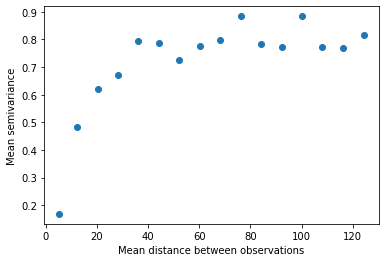

In [34]:
plt.scatter(DE, GE)
plt.xlabel('Mean distance between observations')
plt.ylabel('Mean semivariance')

We will also add the *population variance* in this graph. This is the variance in the data, regardless of spatial dependencies. Let’s check the `help` of the `var` function, and then we will use this function to calculate the variance in the `z` values:

In [35]:
help(np.var)
var_z = np.var(z)

Help on function var in module numpy:

var(a, axis=None, dtype=None, out=None, ddof=0, keepdims=<no value>, *, where=<no value>)
    Compute the variance along the specified axis.
    
    Returns the variance of the array elements, a measure of the spread of a
    distribution.  The variance is computed for the flattened array by
    default, otherwise over the specified axis.
    
    Parameters
    ----------
    a : array_like
        Array containing numbers whose variance is desired.  If `a` is not an
        array, a conversion is attempted.
    axis : None or int or tuple of ints, optional
        Axis or axes along which the variance is computed.  The default is to
        compute the variance of the flattened array.
    
        .. versionadded:: 1.7.0
    
        If this is a tuple of ints, a variance is performed over multiple axes,
        instead of a single axis or all the axes as before.
    dtype : data-type, optional
        Type to use in computing the variance.  Fo

Now, we will draw a horizontal line in the plot that represents the population variance. Let's check the help of the `matplotlib hlines` function and then apply it:

Help on function hlines in module matplotlib.pyplot:

hlines(y, xmin, xmax, colors=None, linestyles='solid', label='', *, data=None, **kwargs)
    Plot horizontal lines at each *y* from *xmin* to *xmax*.
    
    Parameters
    ----------
    y : float or array-like
        y-indexes where to plot the lines.
    
    xmin, xmax : float or array-like
        Respective beginning and end of each line. If scalars are
        provided, all lines will have same length.
    
    colors : list of colors, default: :rc:`lines.color`
    
    linestyles : {'solid', 'dashed', 'dashdot', 'dotted'}, optional
    
    label : str, default: ''
    
    Returns
    -------
    `~matplotlib.collections.LineCollection`
    
    Other Parameters
    ----------------
    data : indexable object, optional
        If given, the following parameters also accept a string ``s``, which is
        interpreted as ``data[s]`` (unless this raises an exception):
    
        *y*, *xmin*, *xmax*, *colors*
    **kwarg

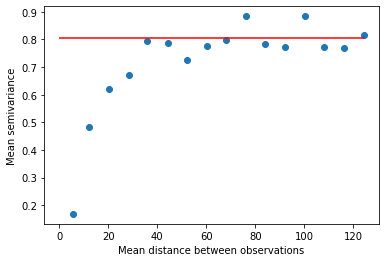

In [38]:
help(plt.hlines)

plt.scatter(DE, GE) # Replot the plot from before
plt.xlabel('Mean distance between observations')
plt.ylabel('Mean semivariance')
plt.hlines(var_z, 0, np.max(DE), color = 'red') # Add population variance

To make sure the graph is nicely plotted we will shift the limit of the y axis a bit. For example, the limit of y axis could have a value that is 10 % larger than the highest observed value. Let’s calculate this value, after which we can use it to set the limits of the y axis:

Text(0, 0.5, 'Averaged semivariance')

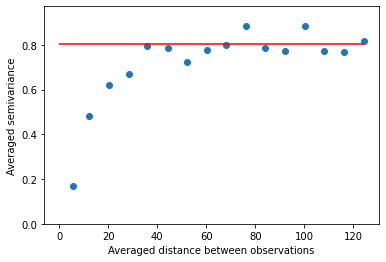

In [39]:
yl = 1.1 * np.max(GE)
plt.scatter(DE, GE) # Replot the plot from before
plt.hlines(var_z, 0, np.max(DE), color = 'red') # Add population variance
plt.ylim((0, yl)) # Change the limit of the y axis
plt.xlabel('Averaged distance between observations')
plt.ylabel('Averaged semivariance')

We can see that the semivariance is small for small distances, and increases for larger distances. The semivariance reaches a plateau that is almost equal to the population variance. This variance is called the **sill**. The distance at which the sill is reached, is called the **range**. This is the length over which spatial dependencies in the data are active. We will plot the variogram again in a new figure, after which we plot some pre-defined regression lines on top of the data:

(0.0, 0.9724665838897022)

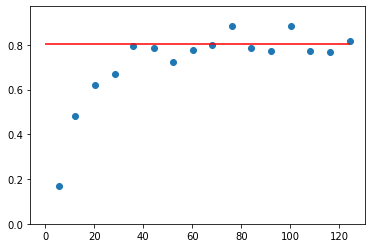

In [40]:
plt.scatter(DE, GE)
plt.hlines(var_z, 0, np.max(DE), color = 'red')
plt.ylim((0, yl))

## Approximating the shape of the variogram using a model

If we want to use the shape and characteristics of our variogram to predict the values of `z` for the areas in between our observations, we need to find a model that approximates the shape of the variogram so we can estimate for each point on a `x`-`y` grid what the `z` value should be and how closely it resembles the neighbouring points. Let's try to do this using a few different models.

First, we will try to fit a **spherical model** to the data without a **nugget**. These are the parameters of the model:

In [41]:
nuggetS = 0 # nugget
sillS = 0.803 # sill
rangeS = 45.9 # range
lags = np.arange(0, np.max(DE)) # bin values

The **nugget** is the intercept of the curve with the y-axis. This is often 0 for spatial data, but could also be a small value.

We can calculate the semivariance for each bin according to this model using the following function:

In [42]:
Gsph = nuggetS + (sillS * (1.5 * lags / rangeS - 0.5 * (lags / rangeS) ** 3) * (lags <= rangeS) + sillS * (lags > rangeS))

Now we can plot the spherical model as a green line on top of the data:

Text(0, 0.5, 'Averaged semivariance')

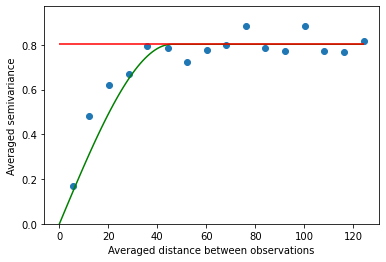

In [43]:
yl = 1.1 * np.max(GE)
plt.scatter(DE, GE) # Replot the plot from before
plt.plot(lags, Gsph, color = 'green') # Plot the spherical model
plt.hlines(var_z, 0, np.max(DE), color = 'red') # Add population variance
plt.ylim((0, yl)) # Change the limit of the y axis
plt.xlabel('Averaged distance between observations')
plt.ylabel('Averaged semivariance')

Secondly, let's try to fit an **exponential model** to our data. The parameters for this model are as follows:

In [45]:
nuggetE = 0.0239 # nugget
sillE = 0.78 # sill
rangeE = 45 # range

We can calculate the modelled semivariance values for this exponental model using the following formula (Note the difference between it and the spherical model!):

In [47]:
Gexp = nuggetE + sillE * (1 - np.exp(-3 * lags / rangeE))

**Exercise 5:** Add the exponential model to your plot using a blue line.

Text(0, 0.5, 'Averaged semivariance')

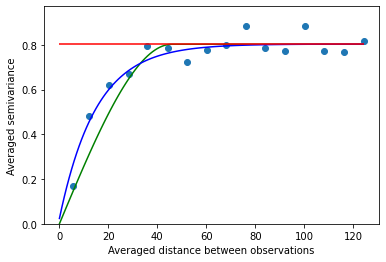

In [56]:
yl = 1.1 * np.max(GE)
plt.scatter(DE, GE) # Replot the plot from before
plt.plot(lags, Gsph, color = 'green') # Plot the spherical model
plt.plot(lags, Gexp, color = 'blue') # Plot the exponential model
plt.hlines(var_z, 0, np.max(DE), color = 'red') # Add population variance
plt.ylim((0, yl)) # Change the limit of the y axis
plt.xlabel('Averaged distance between observations')
plt.ylabel('Averaged semivariance')

Finally, we will try to fit a linear model to our data. These are the parameters we will use for this model:

In [49]:
nuggetL = 0.153 # nugget
slopeL = 0.0203 # slope of the line

The linear model is the simplest model we use (in fact it is just a linear regression, see `Lab01`). It's semivariance values can be calculated from the mean distances of each bin as follows:

In [51]:
Glin = nuggetL + slopeL * lags

**Exercise 6:** Add the linear model to your plot using a purple line and add a legend for all the colors using the following line at the end of your plot statement: `plt.legend(labels = ['Sperical model', 'Exponential model', 'Linear model', 'Variogram', 'Population variance'])`. Make sure the order in which you plot your data and models matches the order in this plot legend statement. You should end up with a plot that shows the data with all three model fits using differently colored lines.

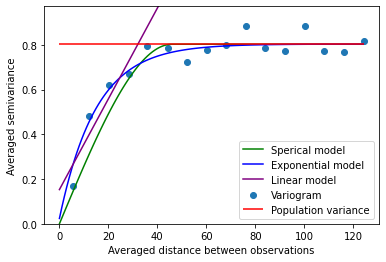

In [55]:
yl = 1.1 * np.max(GE)
plt.plot(lags, Gsph, color = 'green') # Plot the spherical model
plt.plot(lags, Gexp, color = 'blue') # Plot the exponential model
plt.plot(lags, Glin, color = 'purple') # Plot the linear model
plt.scatter(DE, GE) # Replot the plot from before
plt.hlines(var_z, 0, np.max(DE), color = 'red') # Add population variance
plt.ylim((0, yl)) # Change the limit of the y axis
plt.xlabel('Averaged distance between observations')
plt.ylabel('Averaged semivariance')
plt.legend(labels = ['Sperical model', 'Exponential model', 'Linear model', 'Variogram', 'Population variance'])

**Question 5:** Which model best approximates the data in the variogram?

**Answer 5:** The exponential model fits best (but opinions may vary, how would you test the fit?)

## Kriging: Interpolating between our spatial observations

We will use the exponential model with nugget for **kriging**. We will use the  semivariance value derived from this model as weighting factors for the interpolation of `z` values between observations. To do so, first we will apply the model on all distance values in our `D` matrix:

In [57]:
G_mod = (nuggetE + sillE * (1 - np.exp(-3 * D / rangeE))) * (D > 0)

For the calculations that follow, we need to add a row and a column of ones to the matrix, and we will change the bottom right corner of the matrix to a zero:

In [58]:
n = len(x) # n is the number of observations.
G_mod = np.hstack((G_mod, np.ones((n, 1)))) # This adds a row of ones.
G_mod = np.vstack((G_mod, np.ones((1, n + 1)))) # This adds a column of ones (note the n + 1 is needed because we already added the new row).
G_mod[n, n] = 0 # This sets the value of the lower right cell at 0.

`G_mod` now contains modelled semivariance values for each combination of observations. To do kriging, we need the inverse of the semivariance such that pairs with smaller semivariances have a larger weight in the eventual calculation. The `inverse` function (`np.linalg.inv`) will do the job:

In [59]:
G_inv = np.linalg.inv(G_mod)

We will apply the kriging interpolation to a rectangular grid ranging from 0 to 200 in `x` and `y` with a grid size of 5:

In [60]:
R = np.arange(0, 201, 5)

The `meshgrid` function allows us to easily create matrices whose rows and columns contain all combinations of x and y values just like before:

In [61]:
Xg1, Xg2 = np.meshgrid(R, R)

However, we do not want `matrices` of these combinations of x and y values, but we need them in `vectors`. In other words, we have to `reshape` the data. Have a look at the `help` for the `reshape` function:

In [62]:
help(np.reshape)

Help on function reshape in module numpy:

reshape(a, newshape, order='C')
    Gives a new shape to an array without changing its data.
    
    Parameters
    ----------
    a : array_like
        Array to be reshaped.
    newshape : int or tuple of ints
        The new shape should be compatible with the original shape. If
        an integer, then the result will be a 1-D array of that length.
        One shape dimension can be -1. In this case, the value is
        inferred from the length of the array and remaining dimensions.
    order : {'C', 'F', 'A'}, optional
        Read the elements of `a` using this index order, and place the
        elements into the reshaped array using this index order.  'C'
        means to read / write the elements using C-like index order,
        with the last axis index changing fastest, back to the first
        axis index changing slowest. 'F' means to read / write the
        elements using Fortran-like index order, with the first index
        c

The following function will reshape the `Xg1` matrix into a n-by-1 matrix, in which `n` is the total number of values in the matrix:

In [63]:
Xg = Xg1.reshape(((1, -1)), order = "F")[0]

We can do the same for the y coordinates:

In [64]:
Yg = Xg2.reshape(((1, -1)), order = "F")[0]

Now, we will just create some empty (NaN) matrices in which we will store the kriging outputs of the next step. This will be the matrix that will later contain our kriging estimates of `z`:

In [65]:
Zg = Xg * np.nan

This will be the matrix in which we store the kriging variance, which we can use to assess the reliability of our result:

In [66]:
s2_k = Xg * np.nan

Now that everything is in place, we can start with our kriging. This is where we will use some slightly more advanced Python code, so pay close attention to the comments in the code below to make sure you understand what everything does.

In short, we will use a **for-loop** to loop through all the new datapoints and apply the kriging algorithm to estimate the `z` value for each point:

In [68]:
for k in range(len(Xg)): # Loop through all the values in Xg
    DOR = ((x - Xg[k]) ** 2 + (y - Yg[k]) ** 2) ** 0.5 # This is the distance between the grid points (Xg(k),Yg(k)) and the observed points (x, y) using Pythagorean theorem
    G_R = (nuggetL + sillE * (1 - np.exp(-3 * DOR / rangeE))) * (DOR > 0) # We now calculate the semivariance estimated from the variogram for all these distances.
    G_R = np.vstack((G_R, np.ones((1, 1)))) # We add a 1 to the semivariance matrix G_R
    E = np.dot(G_inv, G_R) # To derive the weights E for the kriging operation, we multiply the semivariance vector G_R with G_inv
    Zg[k] = np.sum(E[0:n, 0] * z[:, 0]) # Now we can calculate the z-value of the grid cell as the weighted sum of the observations, E being the weights.
    s2_k[k] = np.sum(E[0:n, 0] * G_R[0:n, 0]) + E[n, 0] # We can also calculate the kriging variance as the weighted sum of the semivariance matrix G_R

## Making sense of our kriging result

OK, that was quite a lot to take in. It's OK if you do not understand all the knitty-gritty detail of the calculations above. What is important is that you see that the algorithm produces estimates of the z values (in vector `Zg`) and estimates of the variance around these values (which can be interpreted as model uncertainty, in `s2_k`).

We now have all our results stored in vectors (with dimentions n by 1). To visualize our kriging result as a map, we want to go back from vectors to matrices (grids) and we can use the `reshape` function again to do this:

In [69]:
r = len(R) # This is the number of rows and columns.

The `reshape` function outputs a grid matrix with r rows/columns from the `Zg` vector:

In [71]:
Z = np.reshape(Zg, (r, r) , order = "F")

And we can do the same for the kriging variance:

In [72]:
SK = np.reshape(s2_k, (r, r) , order = "F")

Now, finally, we can plot our result as a map with x and y coordinates on the horizontal and vertical. We call such a plot where the values in a matrix are represented by a color scale a **pseudocolor plot**. We will use the function `pcolor` (`matplotlob` package) for this. Let's first have a look at the `help` for this function:

In [73]:
help(plt.pcolor)

Help on function pcolor in module matplotlib.pyplot:

pcolor(*args, shading=None, alpha=None, norm=None, cmap=None, vmin=None, vmax=None, data=None, **kwargs)
    Create a pseudocolor plot with a non-regular rectangular grid.
    
    Call signature::
    
        pcolor([X, Y,] C, **kwargs)
    
    *X* and *Y* can be used to specify the corners of the quadrilaterals.
    
    .. hint::
    
        ``pcolor()`` can be very slow for large arrays. In most
        cases you should use the similar but much faster
        `~.Axes.pcolormesh` instead. See
        :ref:`Differences between pcolor() and pcolormesh()
        <differences-pcolor-pcolormesh>` for a discussion of the
        differences.
    
    Parameters
    ----------
    C : 2D array-like
        The color-mapped values.
    
    X, Y : array-like, optional
        The coordinates of the corners of quadrilaterals of a pcolormesh::
    
            (X[i+1, j], Y[i+1, j])       (X[i+1, j+1], Y[i+1, j+1])
                     

The code below walks you through the plot step by step. Make sure you understand what's going on by reading the comments next to each line:

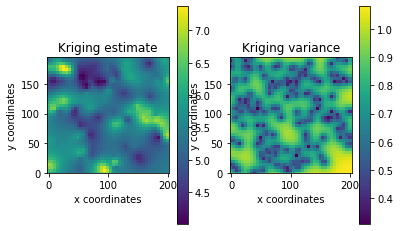

In [75]:
plt.figure()
plt.subplot(121) # This creates enough space for 2 figures next to each other
plt.pcolor(Xg1, Xg2, Z) # Create the pseudocolor plot (map) with Xg1 and Xg2 providing the coordinates and Z containing the values to be plotted as colors.
plt.gca().set_aspect('equal', adjustable='box') # This ensures equal distances for the x and y grid cell intervals in the visualization
plt.ylim((0, 195)) # But now, we need to adjust the limits of y axis so only existing grid cells are displayed
plt.title('Kriging estimate')
plt.xlabel('x coordinates')
plt.ylabel('y coordinates')
plt.colorbar()# This adds a legend for the displayed colors

# We will use the same commands to plot the kriging variance next to it.

plt.subplot(122)
plt.pcolor(Xg1, Xg2, SK) # SK is the estimated kriging variance
plt.gca().set_aspect('equal', adjustable='box')
plt.ylim((0, 195))
plt.title('Kriging variance')
plt.xlabel('x coordinates')
plt.ylabel('y coordinates')
plt.colorbar()

Finally, we can plot the original observations on top of the variance map using the code below:

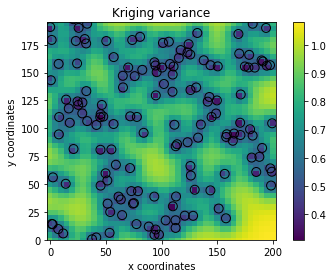

In [76]:
plt.pcolor(Xg1, Xg2, SK) # SK is the estimated kriging variance
plt.gca().set_aspect('equal', adjustable='box')
plt.ylim((0, 195))
plt.title('Kriging variance')
plt.xlabel('x coordinates')
plt.ylabel('y coordinates')
plt.colorbar()
plt.scatter(x, y, s = 80, facecolors = 'none', edgecolors = 'black')

**Question 6:** What do you observe regarding the spatial pattern of the kriging variance in relation to the observed point locations?

**Answer 6:** The kriging variance (uncertainty) is higher in locations where there are less observations. This is exactly what you would expect.